## WEEK 3

#### 1.
Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [1]:
import utils
import pandas as pd
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression

In [2]:
%%time
# выберем зону с наибольшим числом поездок - это будет район Манхэттена, ж/д вокзал Град Сентрал
# подготовленные данные хранятся в БД, будем использовать sql-запросы для выбора данных
aws = utils.AWSUtils()
most_popular_regionid = aws.pd_read_sql(
    sql="SELECT \
        ad.pickup_region_id \
    FROM \
         mldb.taxi_aggregateddata ad \
    GROUP BY \
        ad.pickup_region_id \
    ORDER BY \
        sum(ad.trip_count_sum) DESC \
    LIMIT 1;"
).loc[0][0]
print(most_popular_regionid)

1281
CPU times: user 5.39 ms, sys: 4.15 ms, total: 9.53 ms
Wall time: 13.6 s


In [3]:
%%time
# загрузим данные по этой зоне, кроме июня 2016
# данные собраны за 2 года
data = aws.pd_read_sql(
    sql="SELECT \
        ad.pickup_datetime, \
        ad.trip_count_sum \
    FROM \
        mldb.taxi_aggregateddata ad \
    WHERE \
        ad.pickup_region_id={regionid} \
        AND ad.pickup_datetime<'{max_dt}';"
    .format(
        regionid=most_popular_regionid,
        max_dt='2016-06-01'
    ),
    parse_dates=['pickup_datetime'],
    index_col='pickup_datetime'
)

CPU times: user 260 ms, sys: 15.6 ms, total: 276 ms
Wall time: 42 s


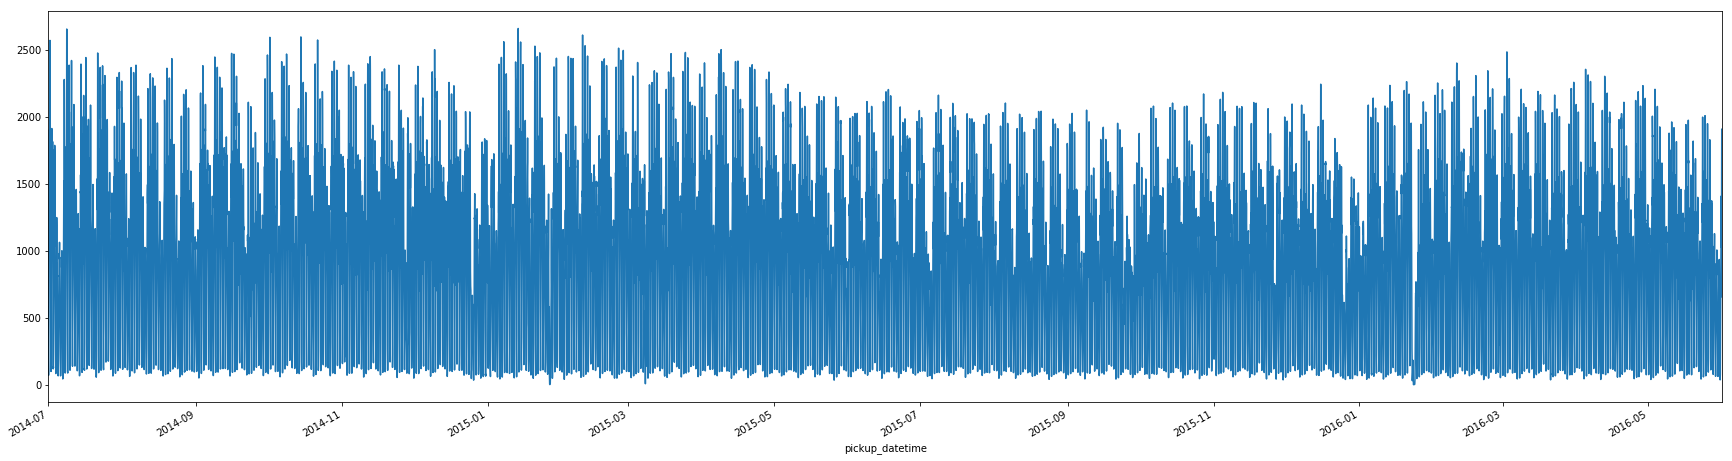

In [4]:
# посмотрим на данные
figsize = (30, 8)
data.trip_count_sum.plot(figsize=figsize)

По графику виден нисходящий тренд, количество пассажиров такси немного уменьшается. Кроме того, явно выражена недельная и годовая сезонность.
Рассмотрим детальнее недельную и дневную сезонность. Для этого посмотрим на данные за месяц

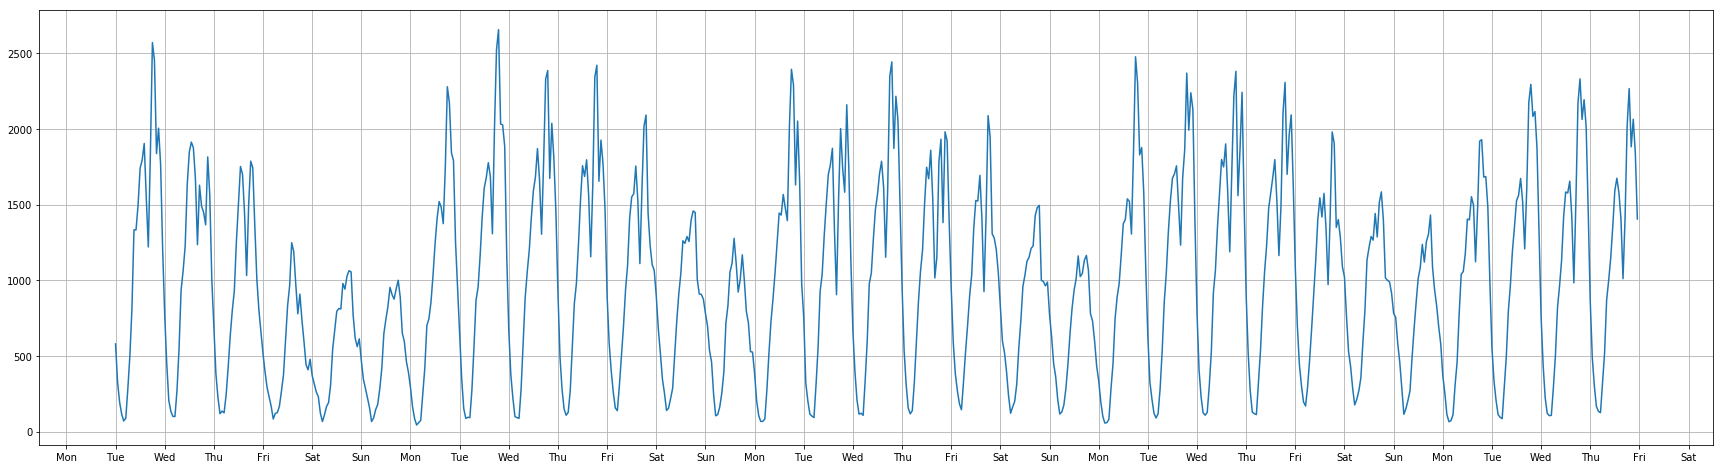

In [5]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data.trip_count_sum.head(24*31))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)

На этом графике видна недельная сезонность (на выходных поездок меньше, при этом минимум приходится на воскресенье), а так же ярко выражена дневная сезонность - минимум поездок приходится на ночь, а максимум - на два пика - утренний и вечерний.
Исходя из этого, создадим регрессионные признаки

In [6]:
def harmonic(df, func, k, period):
    return df.apply(
        lambda x: func(
            df.index.get_loc(x.name)*2*math.pi*k/period
        ),
        axis=1
    )

In [7]:
# регрессионные признаки на основе фурье-гармоник
for k in (3,4,5,6,7,8,9,10):
    week_period=24*7
    year_period=24*365.25
    data.loc[:, 'week_sin_{}'.format(k)] = harmonic(data, math.sin, k, week_period)
    data.loc[:, 'week_cos_{}'.format(k)] = harmonic(data, math.cos, k, week_period)
    data.loc[:, 'year_sin_{}'.format(k)] = harmonic(data, math.sin, k, year_period)
    data.loc[:, 'year_cos_{}'.format(k)] = harmonic(data, math.cos, k, year_period)

# выходной день
data.loc[:, 'isweekend'] = ((data.index.dayofweek)// 5 == 1).astype(float)

#### 2.
Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [8]:
# используем обычную линейную регрессию
model = LinearRegression().fit(
    X=data.iloc[:, 1:], 
    y=data.iloc[:, 0]
)

# посчитаем остатки
data_pred = data[['trip_count_sum']]
data_pred.loc[:, 'pred'] = model.predict(data.iloc[:, 1:])
data_pred.loc[:, 'resid'] = data_pred.loc[:, 'trip_count_sum'] - data_pred.loc[:, 'pred']

Посмотрим на результат работы линейной регрессии
Для более детального анализа сделаем отдельные графики на месяц и на 2 года

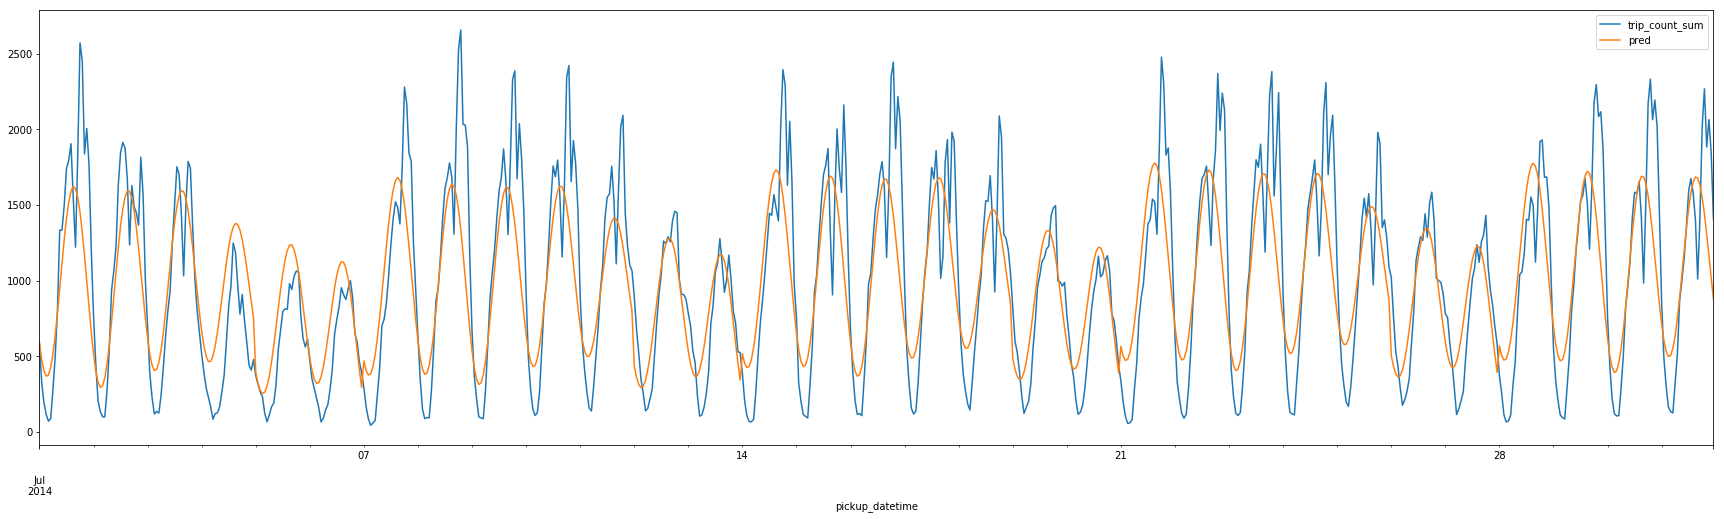

In [9]:
# за месяц
data_pred.head(24*31)[['trip_count_sum', 'pred']].plot(figsize=figsize)

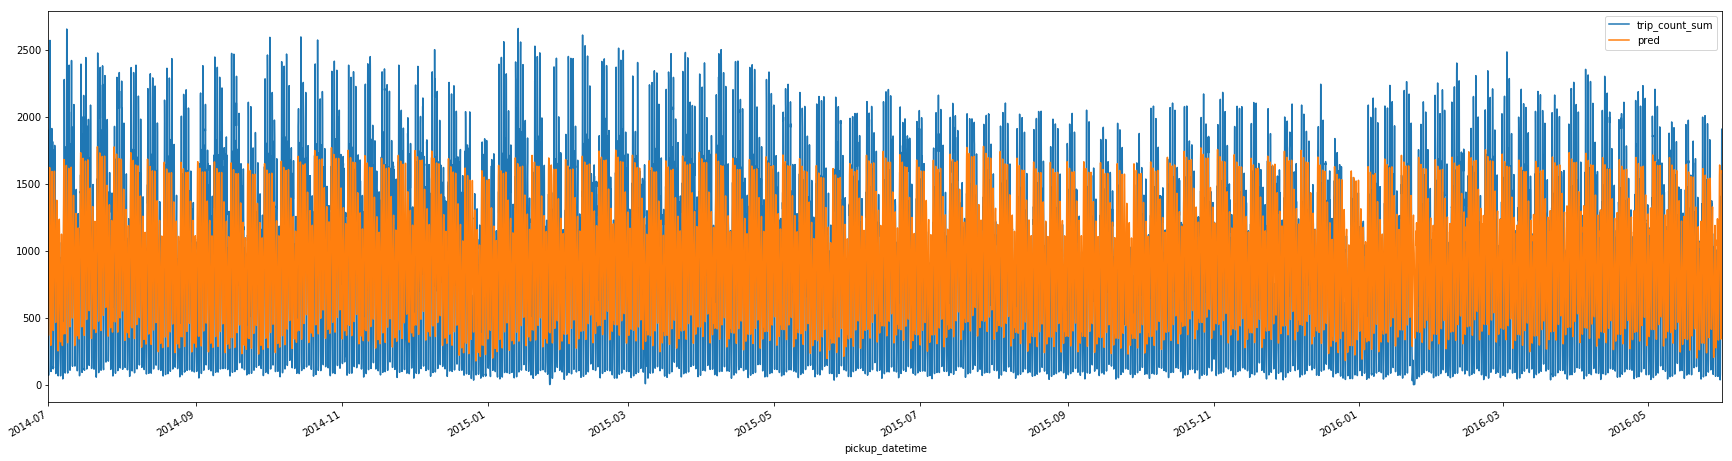

In [10]:
# за 2 года (по всем используемым данным)
data_pred[['trip_count_sum', 'pred']].plot(figsize=figsize)

По графикам видно, что используемые в линейной регрессии признаки довольно неплохо описывают годовую и недельную сезонности.
Теперь посмотрим на остатки линейной регресии, для большей наглядности построим график за 3 месяца

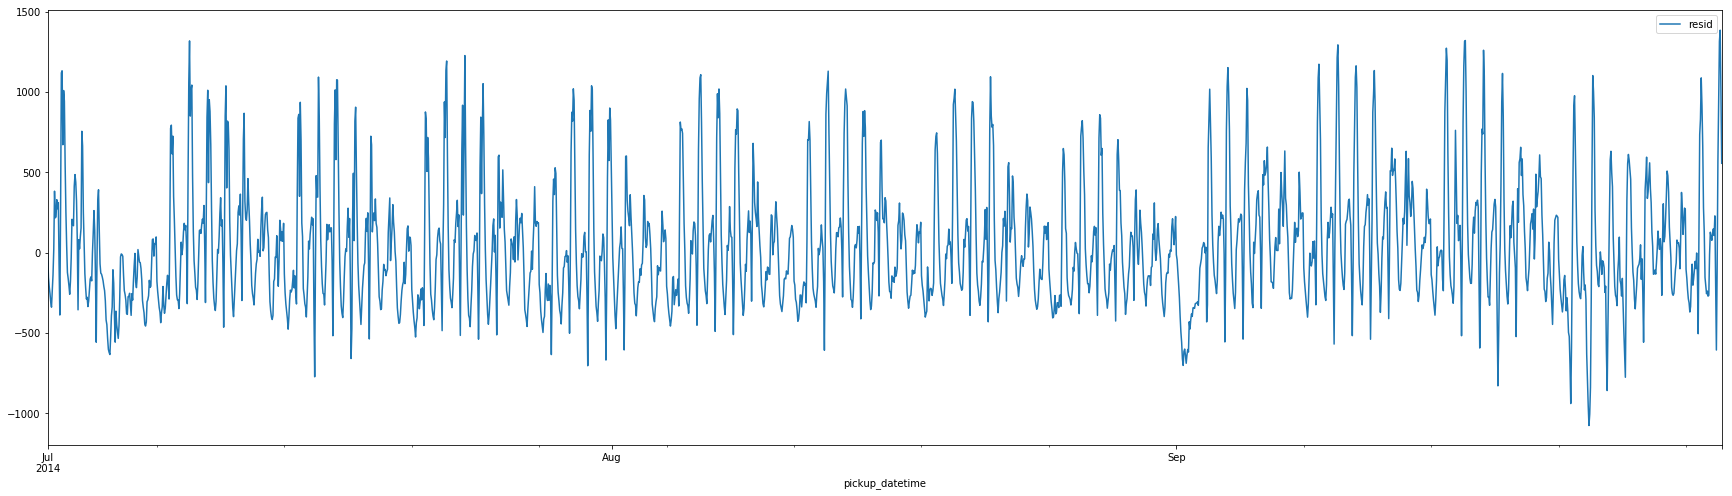

In [11]:
data_pred.head(24*92)[['resid']].plot(figsize=figsize)

По графику видно, что в остатках все-таки осталась недельная сезонность, попробуем решить эту проблему дифференцированием

#### 3.
Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [12]:
def plot_STL(series):
    res = sm.tsa.seasonal_decompose(series)
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(30, 15))
    res.observed.plot(ax=ax1)
    res.trend.plot(ax=ax2)
    res.seasonal.plot(ax=ax3)
    res.resid.plot(ax=ax4)
    
    ax2.set_title('Observed')
    ax2.set_title('Trend')
    ax3.set_title('Seasonal')
    ax4.set_title('Residual')

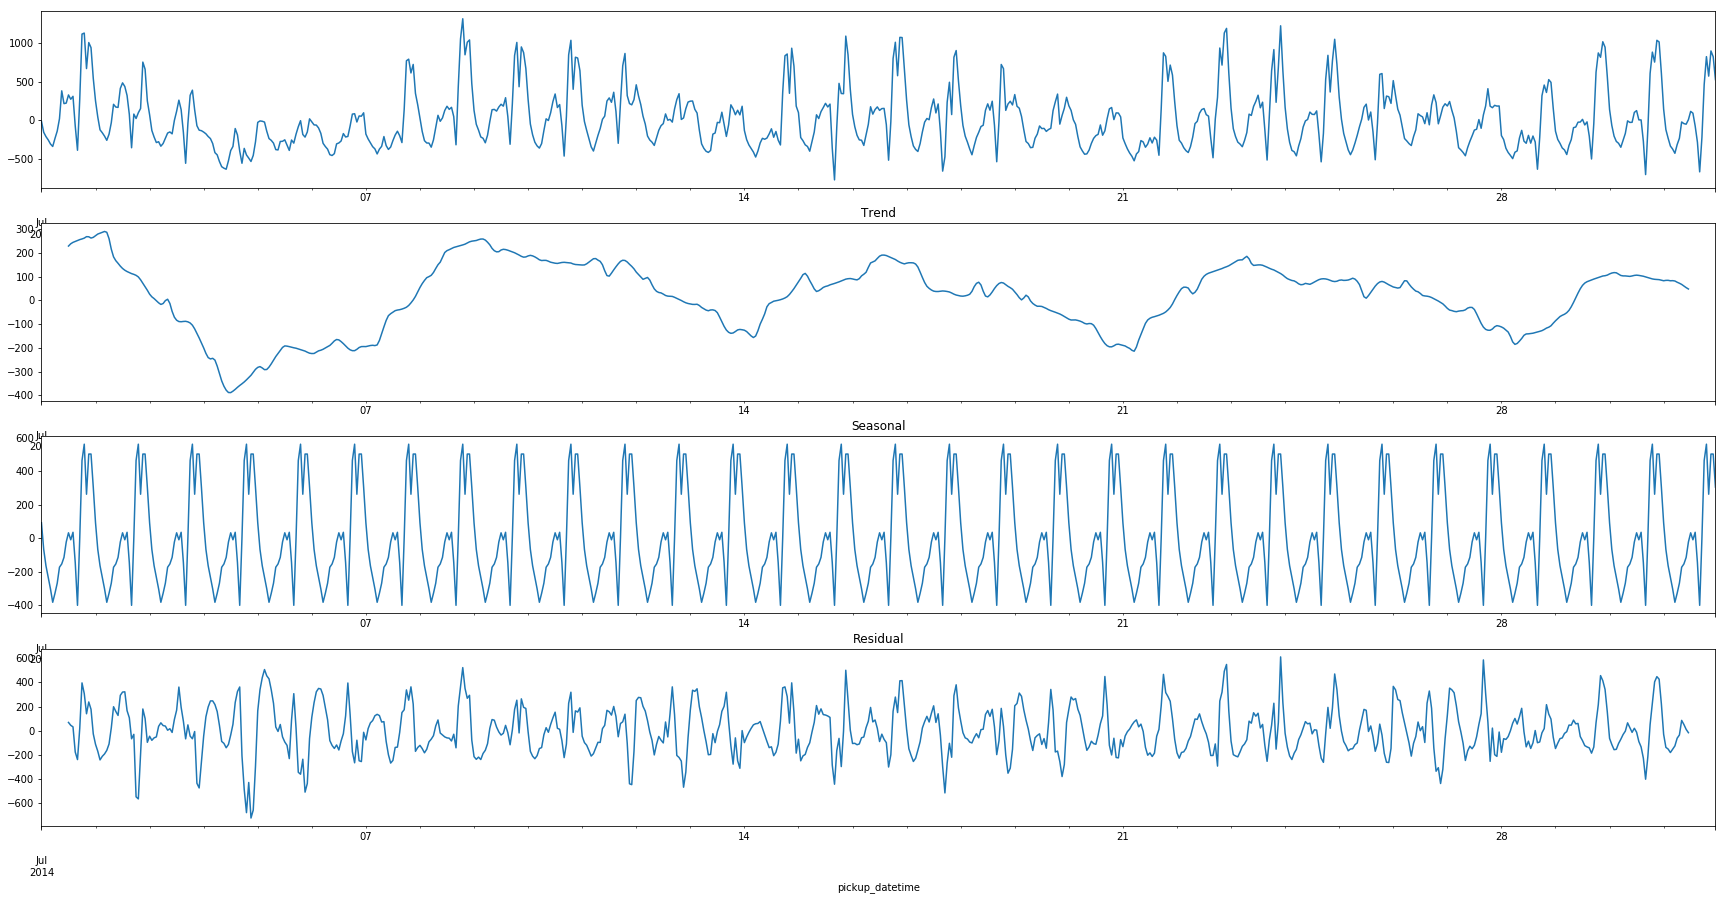

In [13]:
# построим STL-декомпозицию на остатки за месяц
plot_STL(data_pred.head(24*31).resid)

Виден недельный тренд, а также суточная сезонность.
Попробуем сделать недельное сезонное дифференцирование, т.к. внутрисуточная сезонность сильнее зависит от дня недели И времени суток.

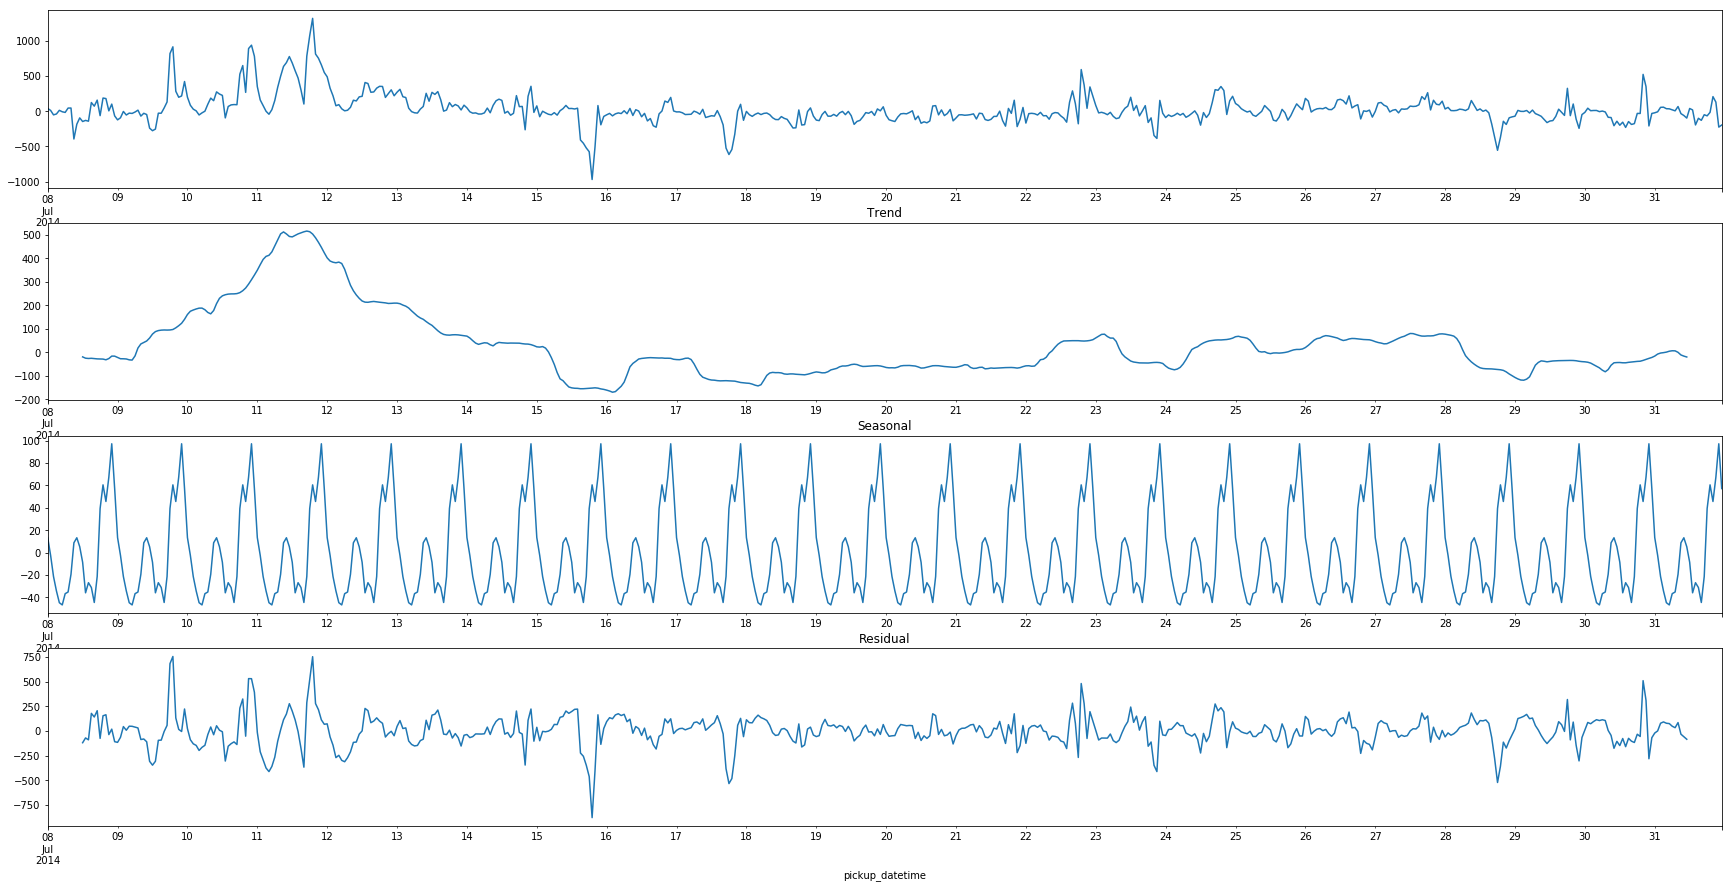

In [16]:
# недельное сезонное дифференцирование
data_pred.loc[:, 'resid_168'] = (data_pred.resid - data_pred.resid.shift(24*7))
plot_STL(data_pred.head(24*31).resid_168.dropna())

Судя по графикам, в остатках структуры нет, однако сохранился тренд. Сделаем обычное дифференцирование

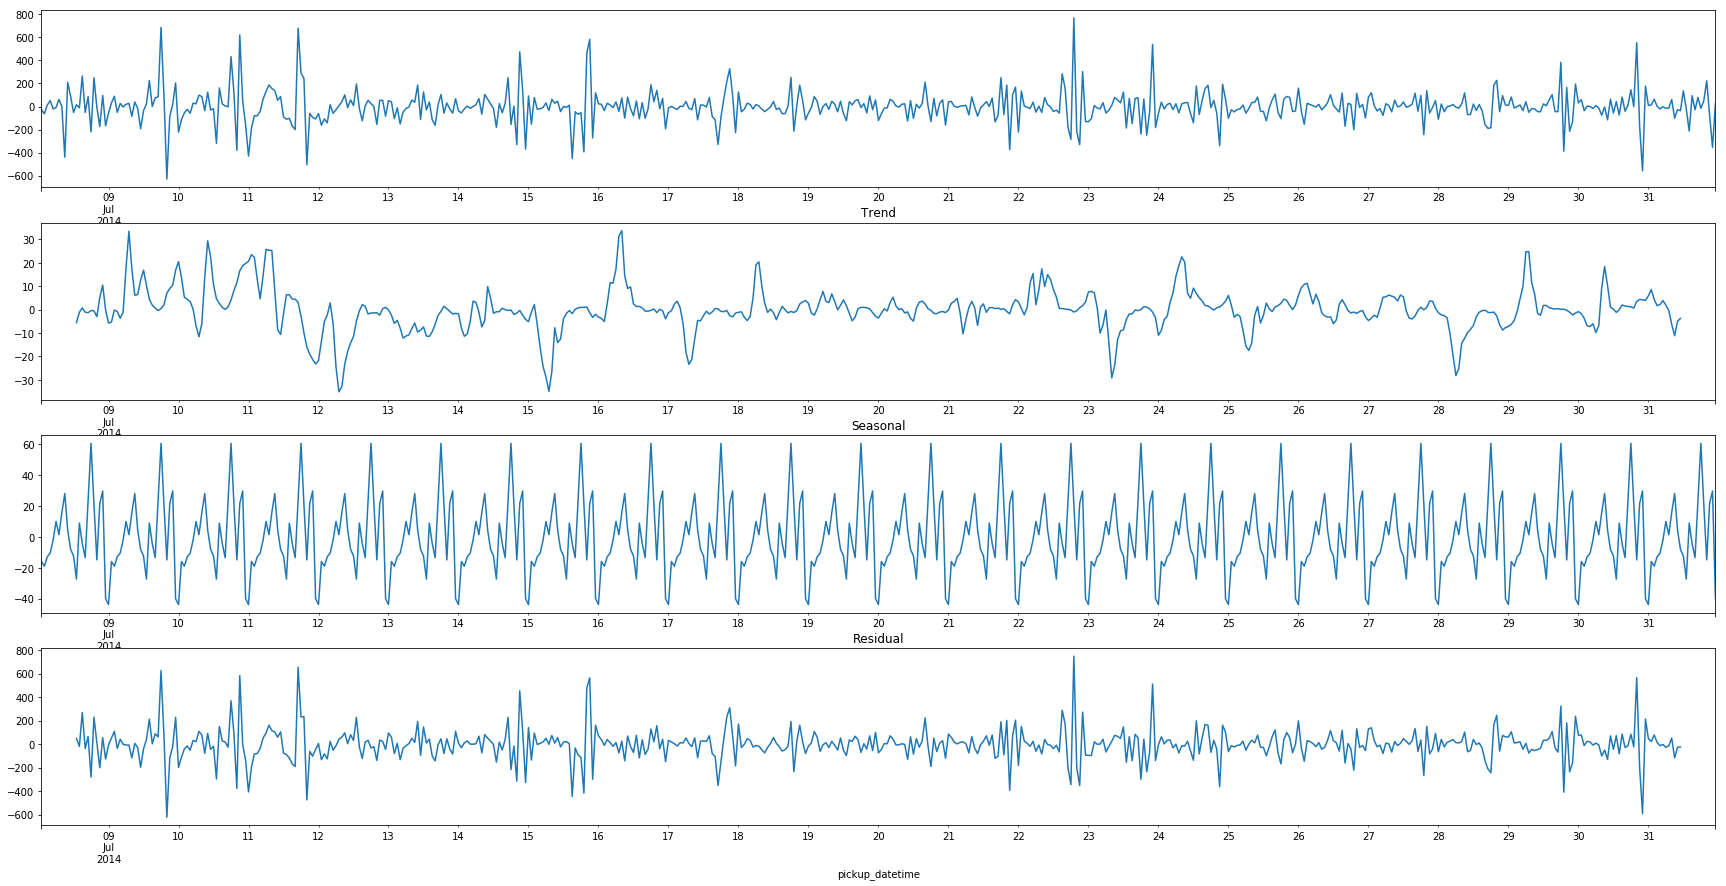

In [19]:
# обычное дифференцирование
data_pred.loc[:, 'resid_168_1'] = (data_pred.resid_168 - data_pred.resid_168.shift(1))
plot_STL(data_pred.head(24*31).resid_168_1.dropna())

После обычного дифференцирования график остатков, судя по всему, близок к случайному шуму.

#### 4.
Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

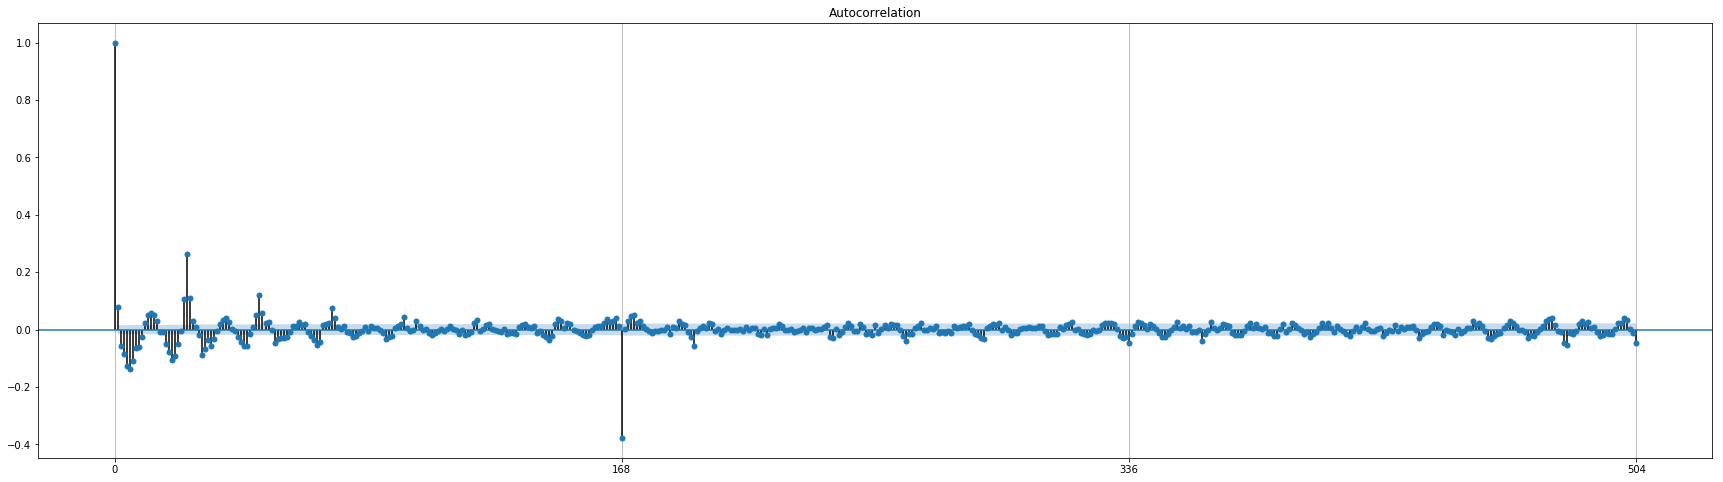

In [23]:
# ACF
# подберем Q - номер последнего сезонного лага, при котором автокорреляция значима
series = data_pred.resid_168_1.dropna()
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_acf(series, lags=24*7*3, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
ax.xaxis.grid(True)

Последний сезонный лаг со значимой автокорреляцией находится на 2 неделе

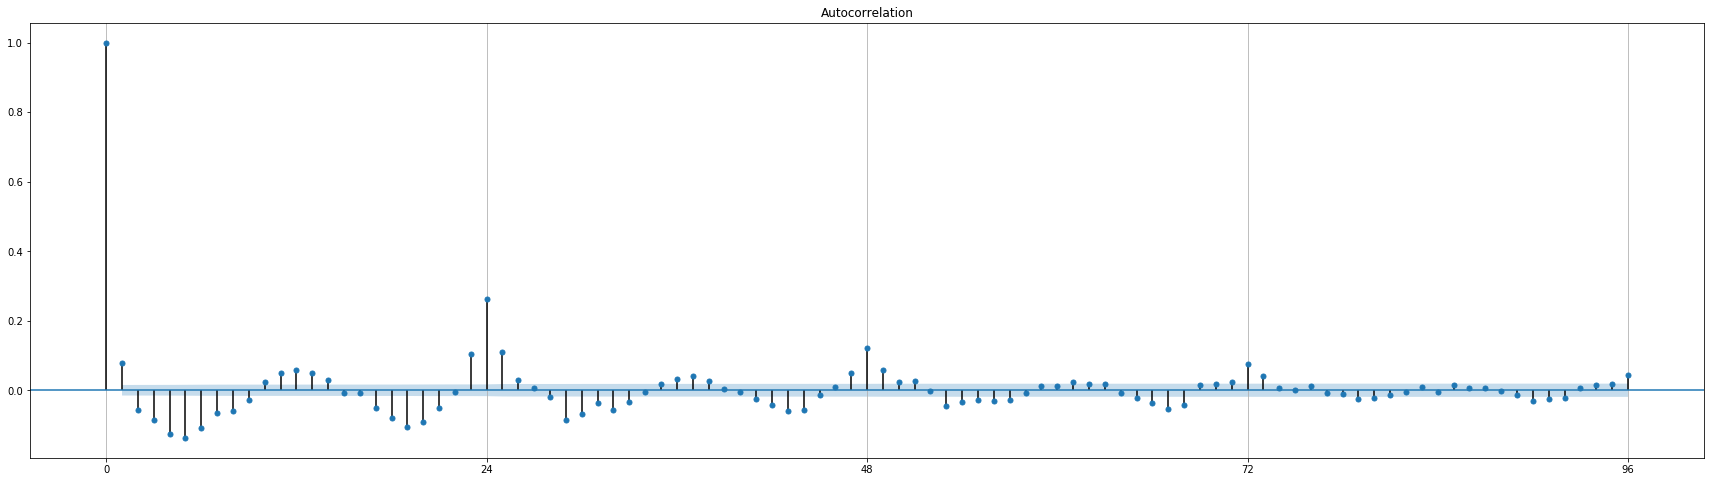

In [25]:
# подберем q - номер последнего несезонного лага, при котором автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_acf(series, lags=24*4, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.xaxis.grid(True)

Последний несезонный лаг со значимой автокорреляцией равен 9

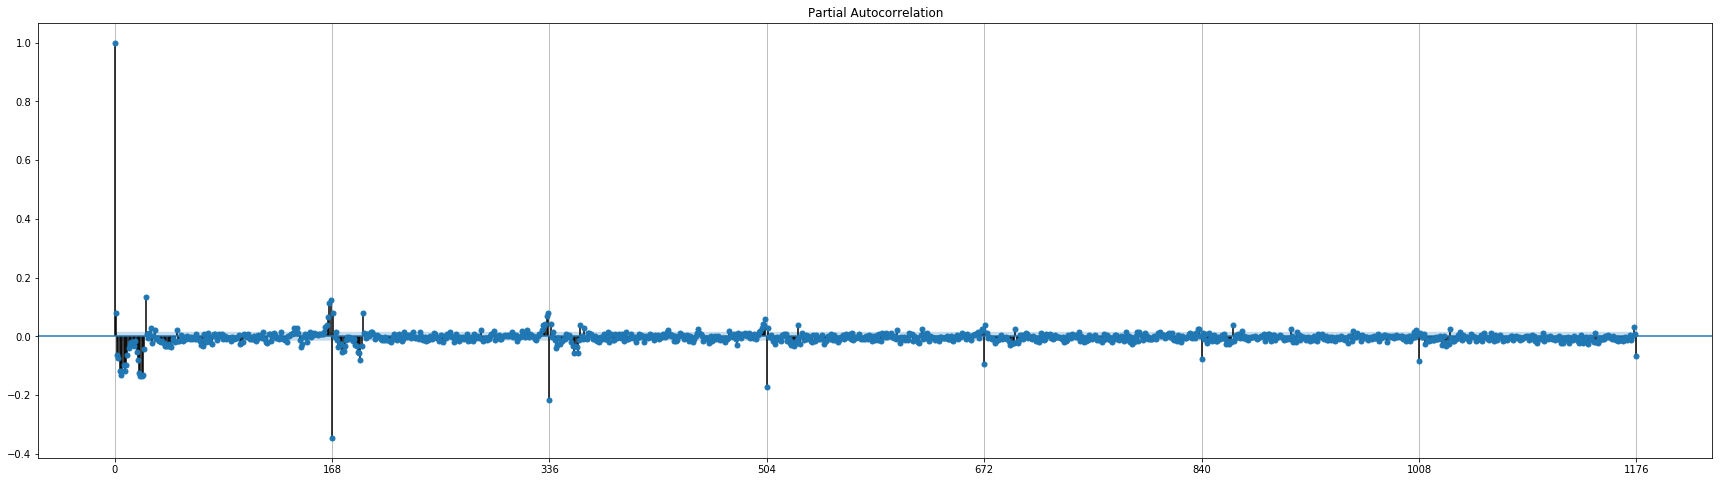

In [32]:
# PACF
# подберем P - номер последнего сезонного лага, при котором частичная автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_pacf(series, lags=24*7*7, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
ax.xaxis.grid(True)

Значение последнего сезонного лага со значимой автокорреляцией довольно велико, потому ограничимся числом 7. При бОльших значениях P не хватает ресурсов для вычисления модели

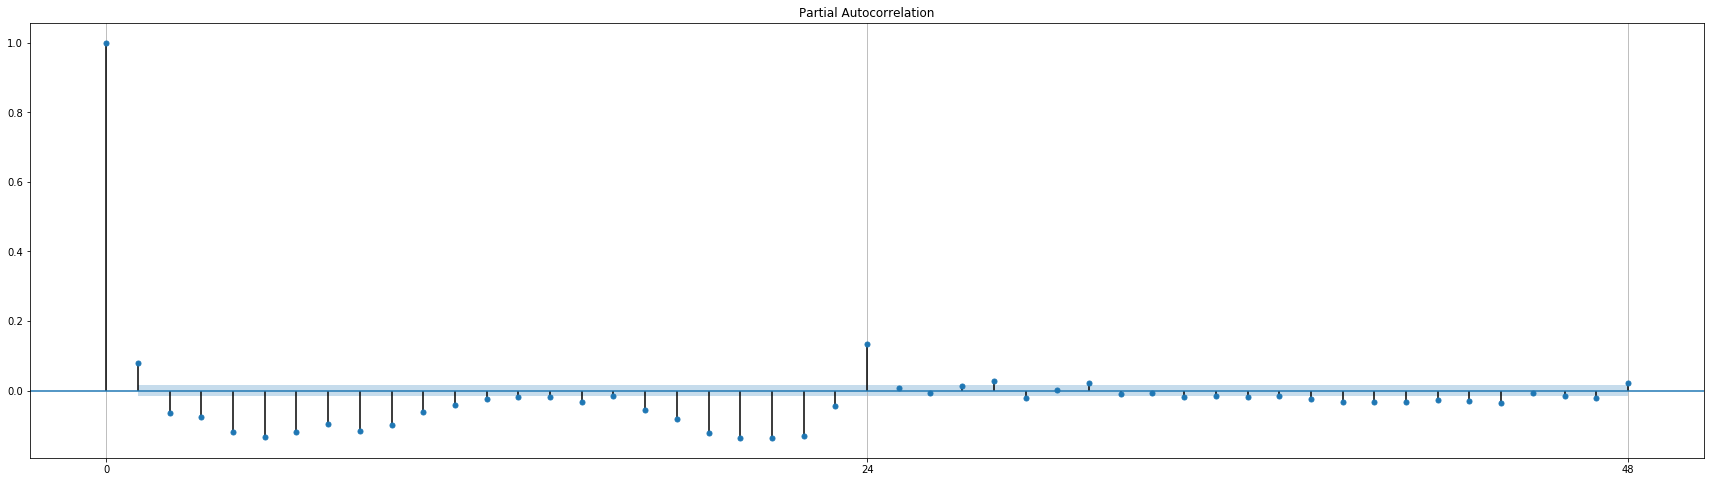

In [34]:
# подберем p - номер последнего несезонного лага, при котором автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_pacf(series, lags=24*2, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.xaxis.grid(True)

Последний несезонный лаг со значимой автокорреляцией равен 12

#### 5.
Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.

Будем строить модель по остаткам от линейной регрессии, т.к. SARIMAX - тяжелый алгоритм, а построенная линейная регрессия довольно неплохо описывает зависимости в данных

In [35]:
# класс для подбора оптимальных по aic параметров
# значительно сокращает число переборов
class ParamGenerator():
    def __init__(self, p, q, P, Q, order=[0,1,2,3]):
        self.max_params = [p,q,P,Q]
        self.current_params = [0,0,0,0]
        self.best_params = [0,0,0,0]
        self.order_index = 0
        self.max_index = 3
        self.best_aic = float("inf")
        self.base_aic = float("inf")
        self.completed = False
        self.order=order
        self.step=0
        
    def get_index(self):
        return self.order[self.order_index]
    
    def get_params(self, last_aic):
        
        # значения параметров, текущее и максимальное
        current_value = self.current_params[self.get_index()]
        max_value = self.max_params[self.get_index()]
        
        # сохранение оптимального по aic значения параметра
        if last_aic < self.best_aic:
            self.best_aic = last_aic
            self.best_params[self.get_index()] = self.current_params[self.get_index()]
        
        # инициализация - в качестве baseline принимается aic при стартовых значениях параметров
        if self.step == 0 and last_aic != float("inf"):
            self.base_aic = last_aic
            self.step = 1
        
        # перебираются возможные значения каждого параметра, при этом остальные параметры фиксируются в 0
        elif self.step == 1:
            if self.order_index == self.max_index and current_value == max_value:
                self.step = 2
                self.current_params = self.best_params[:]
                self.order_index = 0
                self.best_aic = self.base_aic
            
            else:
                if current_value == max_value:
                    self.current_params[self.get_index()] = 0
                    self.order_index += 1
                    self.best_aic = self.base_aic
                
                self.current_params[self.get_index()] += 1
        
        # каждый по очереди параметр уменьшается на 1, и проверяется aic модели
        elif self.step == 2:
            switch_index = (current_value == 0 or last_aic > self.best_aic)
            
            if self.order_index == self.max_index and switch_index:
                self.completed = True
                
            else:
                if switch_index:
                    self.current_params[self.get_index()] = self.best_params[self.get_index()]
                    self.order_index += 1
                
                self.current_params[self.get_index()] -= 1    
        
        return self.current_params

In [36]:
def calc_sarimax(data,order,seasonal_order,exog=None,return_model=False,simple_differencing=True):
    model = sm.tsa.statespace.SARIMAX(
        data,
        order=order,
        seasonal_order=seasonal_order,
        exog=exog,
        simple_differencing=simple_differencing,
        initialization='approximate_diffuse',
        low_memory=True
    ).fit(disp=-1)
    
    if return_model:
        return model
    else:
        return model.aic

In [141]:
def test_params(data, p, q, P, Q, D, d, s, exog=None):
    aic = float("inf")
    max_loop_count = (p+q+P+Q)*2
    params = ParamGenerator(p, q, P, Q)

    try:
        warnings.filterwarnings('ignore')
        for i in range(1, max_loop_count + 1):

            param = params.get_params(aic)
            if params.completed:
                break

            try:
                print('{}/{}: {}'.format(i, max_loop_count, param))
                aic=calc_sarimax(
                    data,
                    exog=exog,
                    order=(param[0], d, param[1]),
                    seasonal_order=(param[2], D, param[3], s),
                )
                print(aic)

            except ValueError:
                continue

    finally:
        warnings.filterwarnings('default')
    
    return params.best_params

In [38]:
%%time
Q = 2
q = 9
P = 7
p = 12
D = 1
d = 1
s = 24 # период 24 часа
best_param = test_params(data_pred.resid, p, q, P, Q, D, d, s)

1/60: [0, 0, 0, 0]
217254.39302932168
2/60: [0, 0, 0, 0]
217254.39302932168
3/60: [1, 0, 0, 0]
216786.41448404116
4/60: [2, 0, 0, 0]
216716.11381410842
5/60: [3, 0, 0, 0]
216385.28412946715
6/60: [4, 0, 0, 0]
215893.55053357416
7/60: [5, 0, 0, 0]
215557.3901318444
8/60: [6, 0, 0, 0]
215412.23456794696
9/60: [7, 0, 0, 0]
215169.0631590895
10/60: [8, 0, 0, 0]
214545.97269815757
11/60: [9, 0, 0, 0]
214314.9984049881
12/60: [10, 0, 0, 0]
214260.2455583754
13/60: [11, 0, 0, 0]
214186.3601918226
14/60: [12, 0, 0, 0]
214165.23906193185
15/60: [0, 1, 0, 0]
216756.47783226747
16/60: [0, 2, 0, 0]
216758.38205943588
17/60: [0, 3, 0, 0]
216255.64804659568
18/60: [0, 4, 0, 0]
215155.75133416834
19/60: [0, 5, 0, 0]
214344.97301079496
20/60: [0, 6, 0, 0]
214214.0644169591
21/60: [0, 7, 0, 0]
214213.29223066778
22/60: [0, 8, 0, 0]
214138.58511579732
23/60: [0, 9, 0, 0]
214134.32119805727
24/60: [0, 0, 1, 0]
216769.82050321557
25/60: [0, 0, 2, 0]
216181.93971115426
26/60: [0, 0, 3, 0]
215155.90740088
2

In [39]:
print('The best params (p,q,P,Q): {}'.format(best_param))

The best params (p,q,P,Q): [1, 9, 7, 2]


In [40]:
%%time
model = calc_sarimax(
    data_pred.resid,
    order=(best_param[0], d, best_param[1]),
    seasonal_order=(best_param[2], D, best_param[3], s),
    return_model=True
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 12h 9min 35s, sys: 8min 2s, total: 12h 17min 38s
Wall time: 1h 28min 10s


In [41]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       D.DS24.resid   No. Observations:                16792
Model:             SARIMAX(1, 0, 9)x(7, 0, 2, 24)   Log Likelihood             -101986.072
Date:                            Mon, 30 Mar 2020   AIC                         204012.143
Time:                                    08:00:42   BIC                         204166.716
Sample:                                         0   HQIC                        204063.146
                                          - 16792                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9972      0.015    -68.133      0.000      -1.026      -0.969
ma.L1          0.9725      0.762   

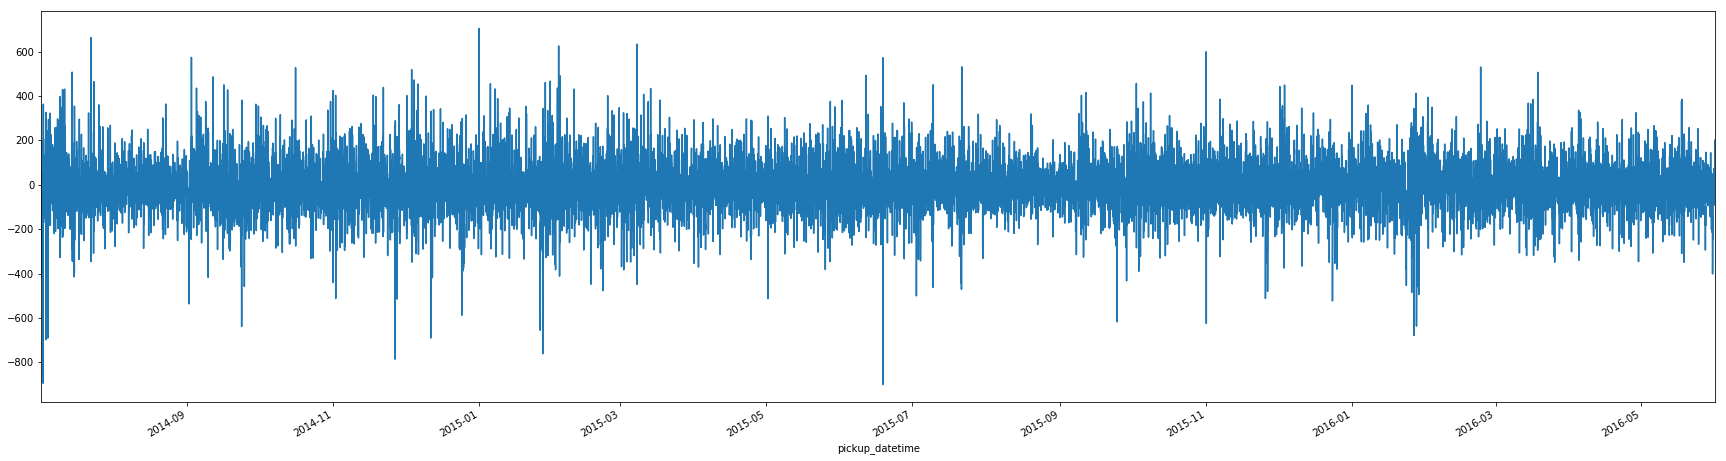

In [42]:
# график остатков
model.resid.plot(figsize=figsize)

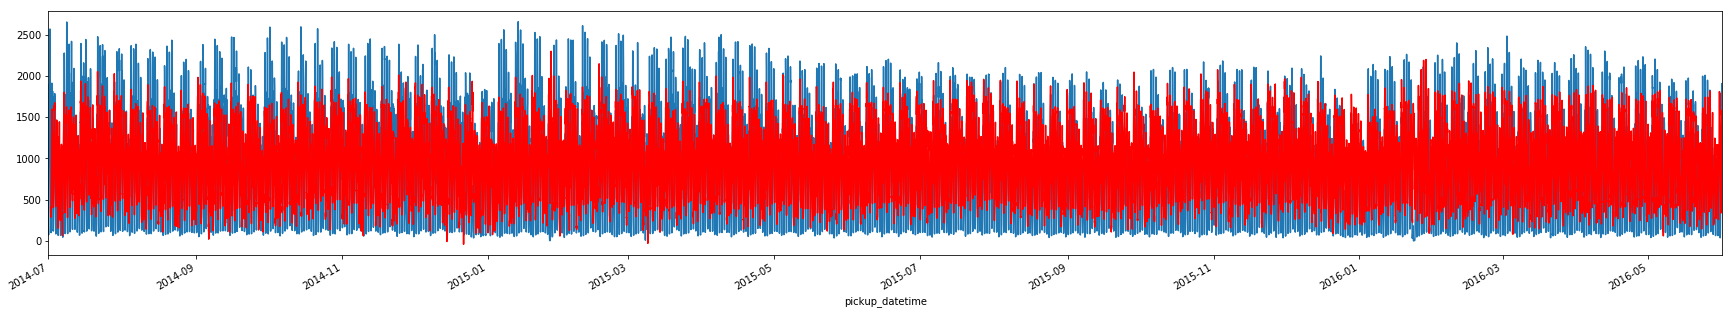

In [43]:
# итоговый прогноз - сумма прогноза линейной регрессии и построенной модели по ее остаткам
data_pred['model'] = data_pred.loc[:, 'pred'] + model.fittedvalues

# результаты за 2 года
plt.figure(figsize=figsize)
data_pred.trip_count_sum.plot()
data_pred.model.plot(color='r')

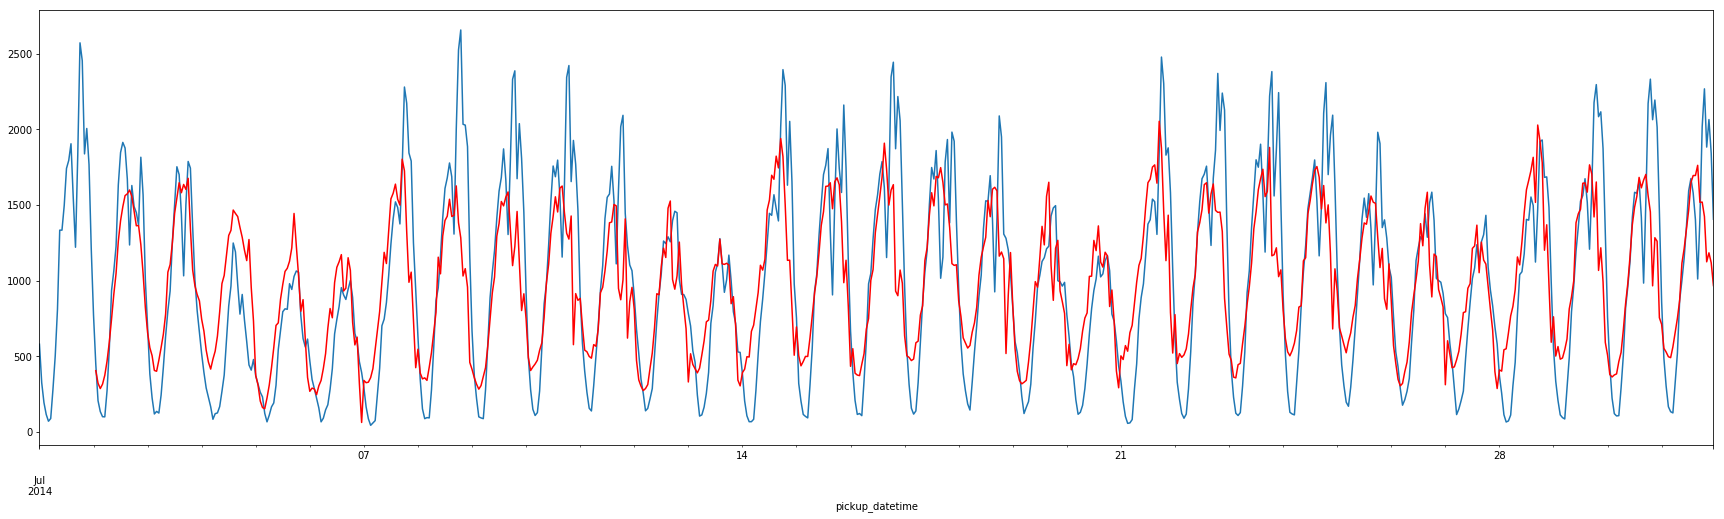

In [44]:
# результаты за первый месяц
data_pred.trip_count_sum.head(24*31).plot(figsize=figsize)
data_pred.model.head(24*31).plot(color='r')

#### 6.
Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Судя по полученным результатам, в построенной модели за 2 года, в целом, неплохо смоделировалась годовая сезонность (виден спад поездок на такси в январе), а также недельная сезонность. Однако, суточная сезонность моделью описана плохо, видно, что в ночные часы количество поездок завышено, а в дневные - наоборот, занижено.
Прогнозирование на двухлетних данных очень ресурсоемко (использовался инстанс m5.4xlarge, построение одной модели занимало в среднем 1.5 часа), потому, сократим период до полугода и попробуем улучшить модель

In [48]:
# данные за полгода (с января по май)
data_5_month = data.tail(24*152)
data_5_month.head()

trip_count_sum
pickup_datetime                    
2016-01-01 00:00:00          1076.0
2016-01-01 01:00:00          1178.0
2016-01-01 02:00:00          1053.0
2016-01-01 03:00:00           610.0
2016-01-01 04:00:00           401.0

In [49]:
data_pred = data_5_month.copy()

Построим новые регрессионные признаки

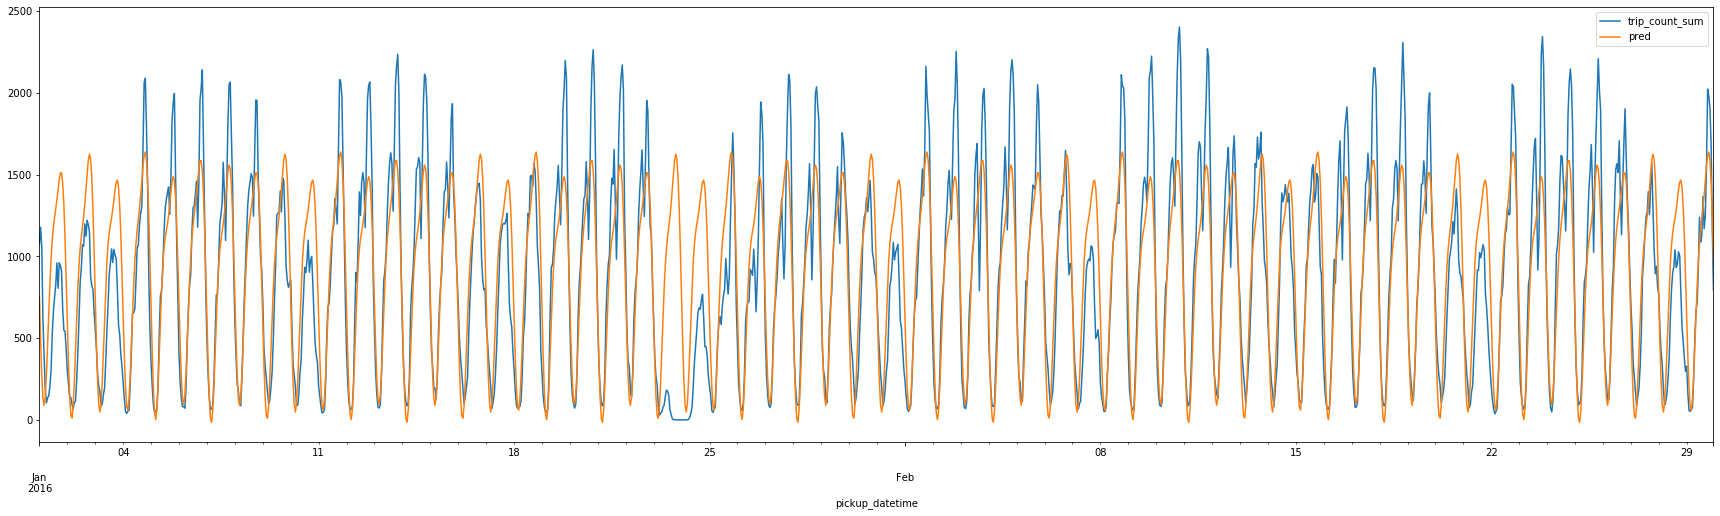

In [219]:
# регрессионные признаки на основе фурье-гармоник
data_pred = data_5_month.copy()

for k in (4,7,11,14):
    week_period=24*7
    data_pred.loc[:, 'week_sin_{}'.format(k)] = harmonic(data_pred, math.sin, k, week_period)
    data_pred.loc[:, 'week_cos_{}'.format(k)] = harmonic(data_pred, math.cos, k, week_period)

# используем обычную линейную регрессию
model = LinearRegression().fit(
    X=data_pred.iloc[:, 1:], 
    y=data_pred.iloc[:, 0]
)

# посчитаем остатки
data_pred.loc[:, 'pred'] = model.predict(data_pred.iloc[:, 1:])
data_pred.loc[:, 'resid'] = data_pred.loc[:, 'trip_count_sum'] - data_pred.loc[:, 'pred']
data_pred.head(24*60)[['trip_count_sum', 'pred']].plot(figsize=figsize)

Проведем заново анализ остатков для подбора p, q, P, Q

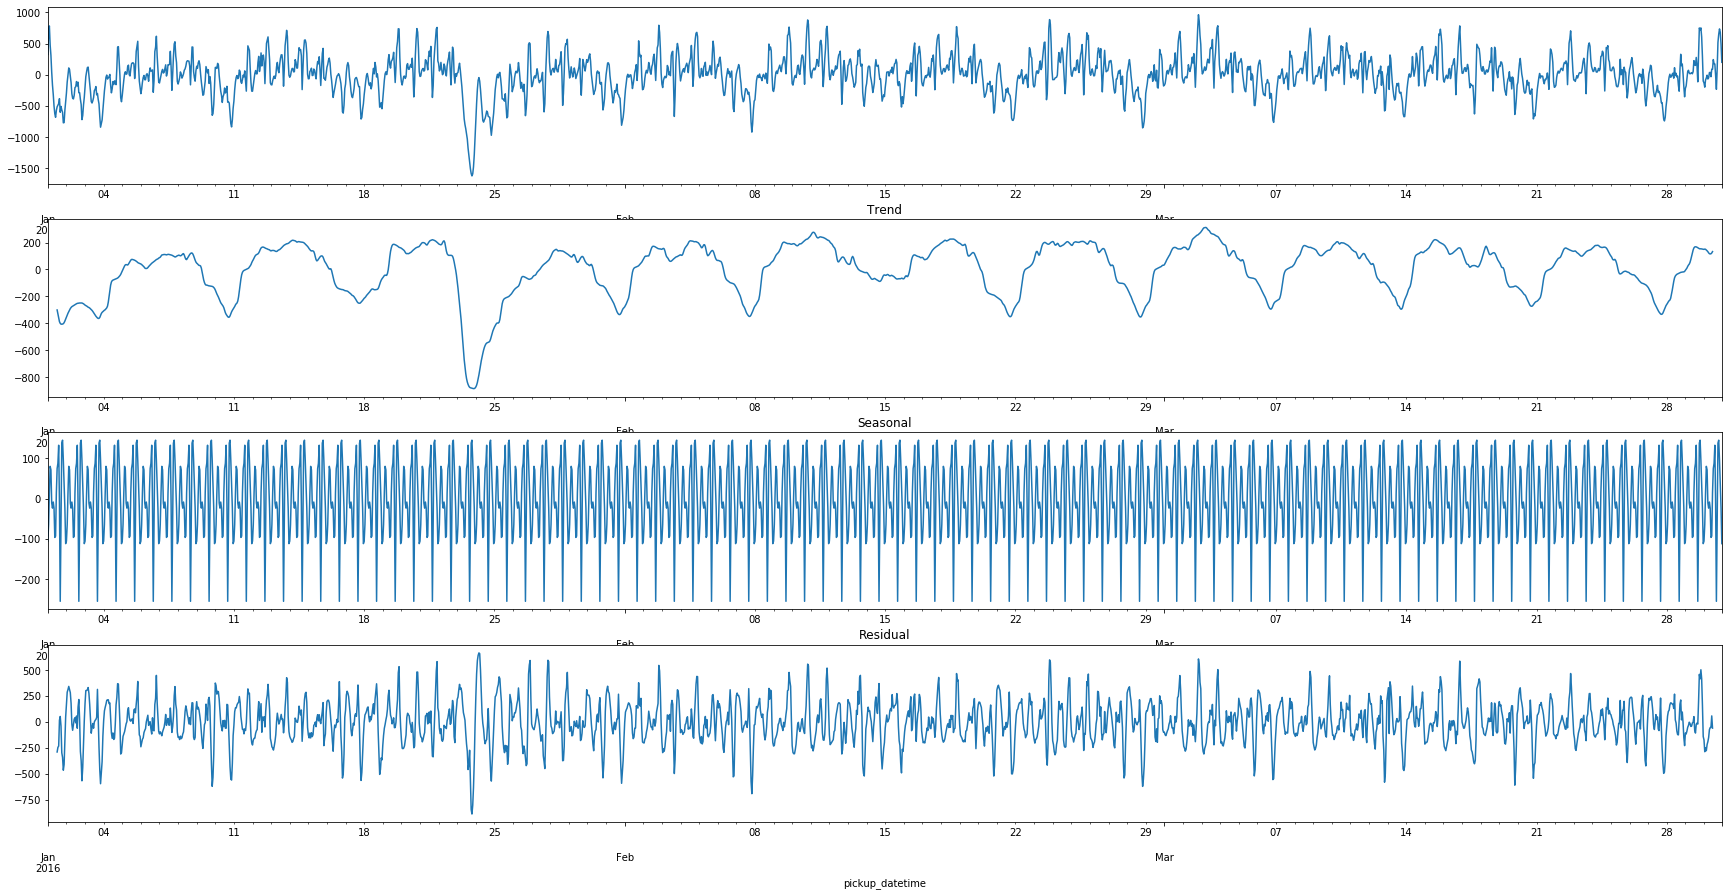

In [220]:
# построим STL-декомпозицию на остатки за месяц
plot_STL(data_pred.head(24*90).resid)

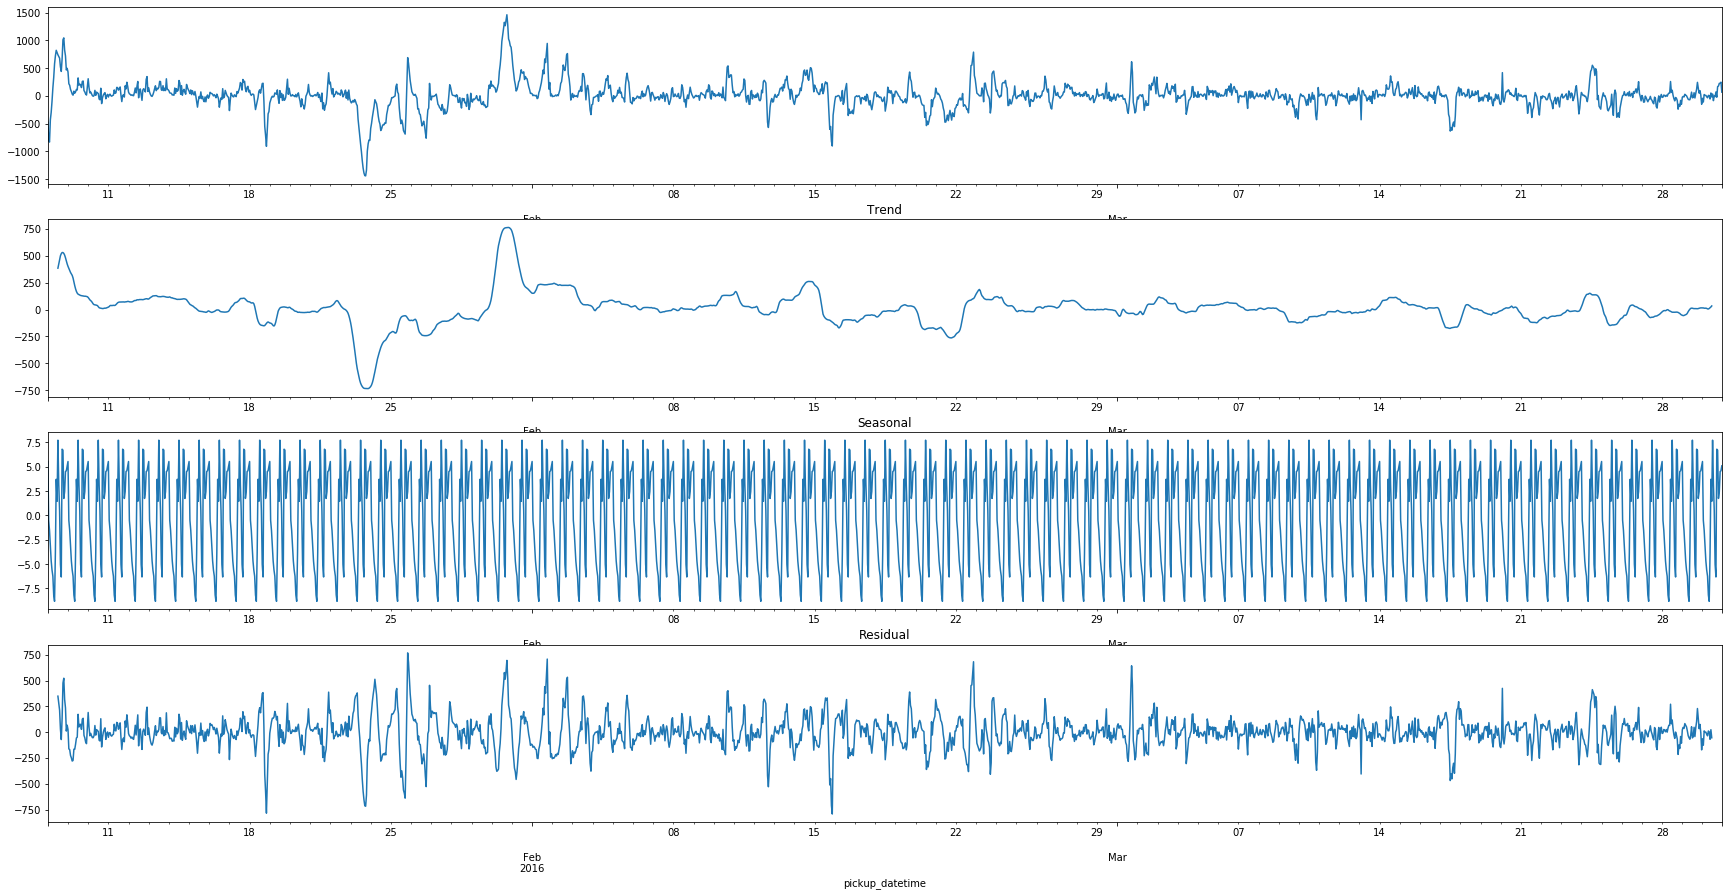

In [205]:
# недельное сезонное дифференцирование
data_pred.loc[:, 'resid_168'] = (data_pred.resid - data_pred.resid.shift(24*7))
plot_STL(data_pred.head(24*90).resid_168.dropna())

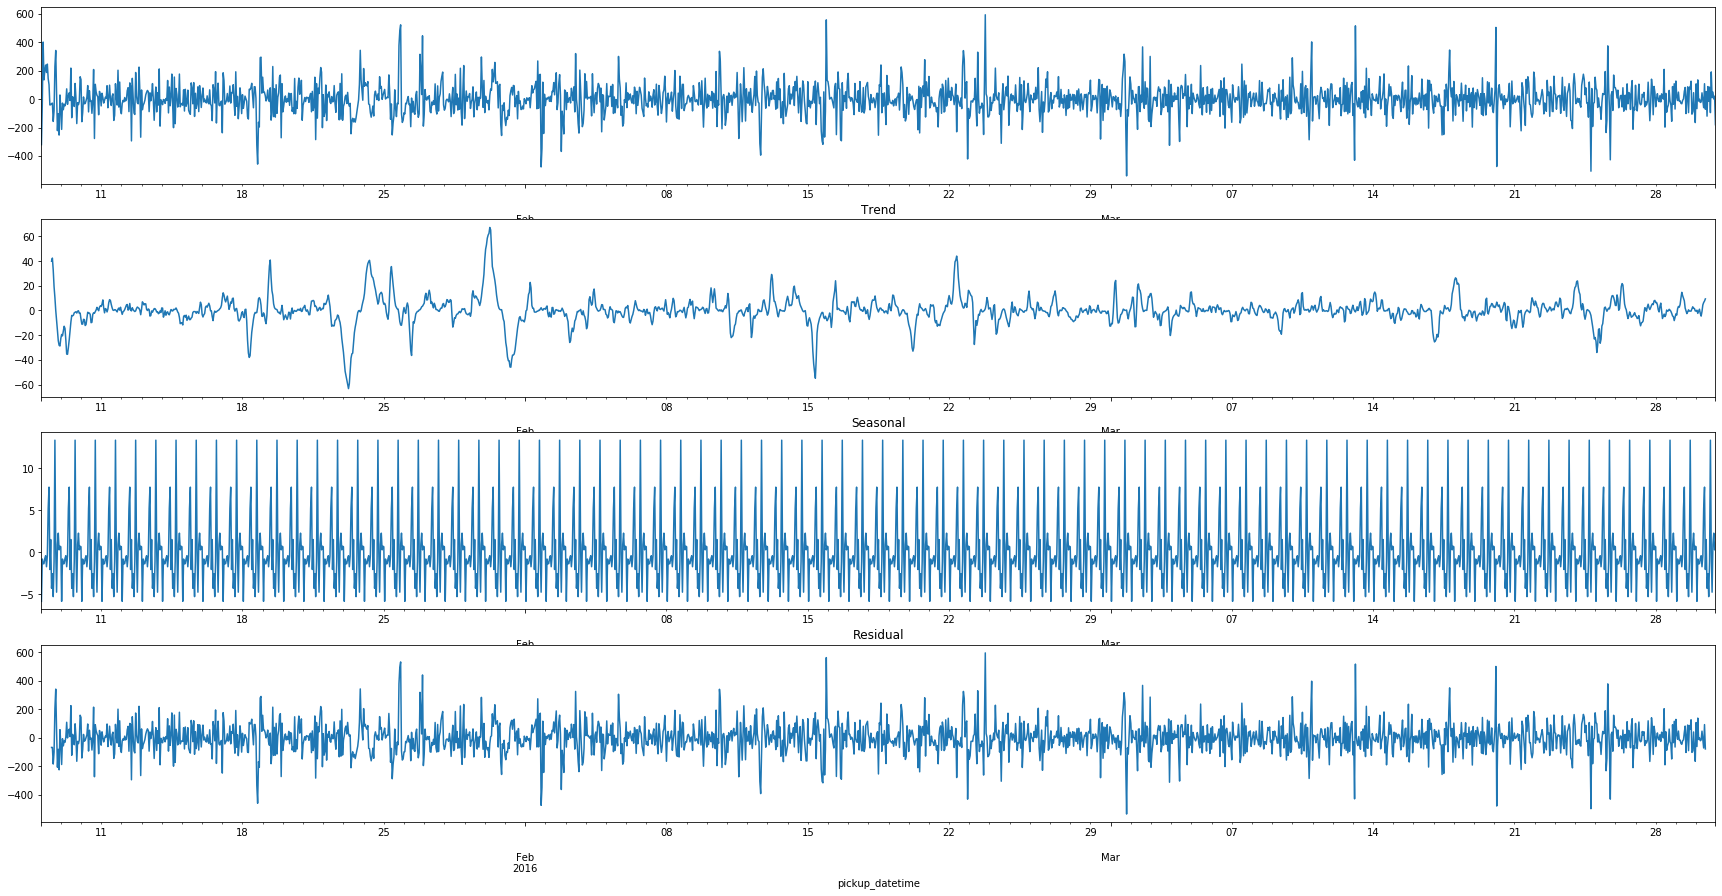

In [206]:
# обычное дифференцирование
data_pred.loc[:, 'resid_168_1'] = (data_pred.resid_168 - data_pred.resid_168.shift(1))
plot_STL(data_pred.head(24*90).resid_168_1.dropna())

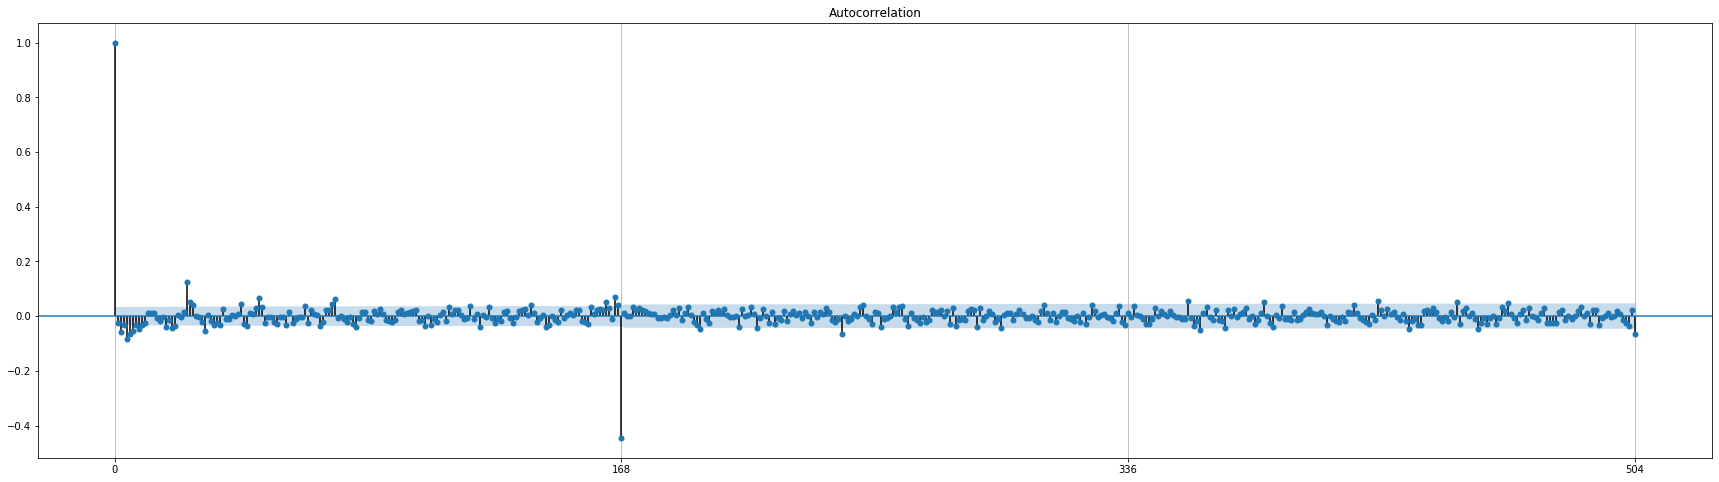

In [207]:
# ACF
# подберем Q - номер последнего сезонного лага, при котором автокорреляция значима
series = data_pred.resid_168_1.dropna()
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_acf(series, lags=24*7*3, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
ax.xaxis.grid(True)

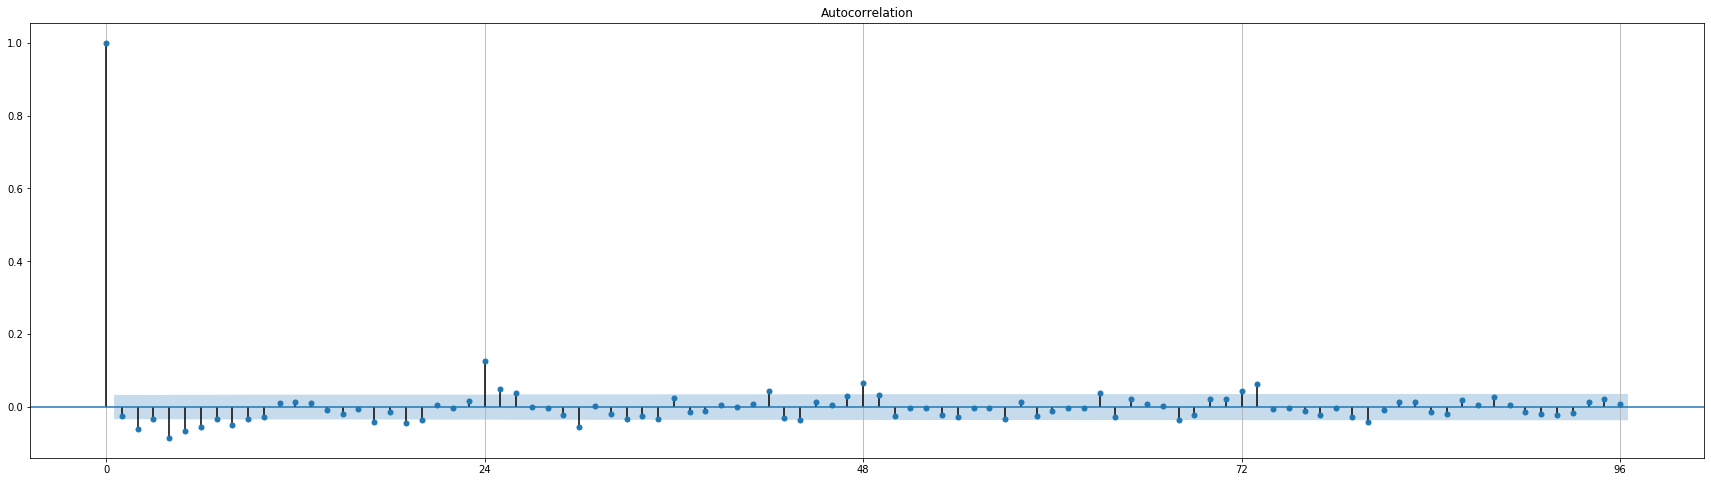

In [208]:
# подберем q - номер последнего несезонного лага, при котором автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_acf(series, lags=24*4, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.xaxis.grid(True)

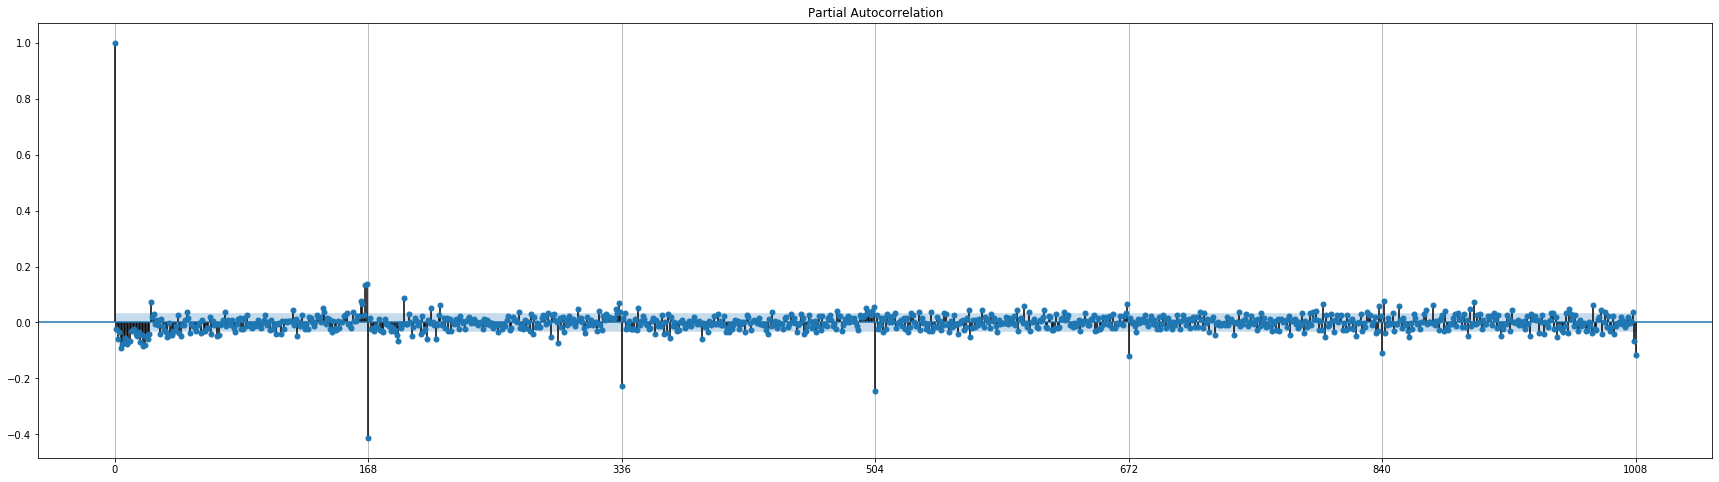

In [209]:
# PACF
# подберем P - номер последнего сезонного лага, при котором частичная автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_pacf(series, lags=24*7*6, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
ax.xaxis.grid(True)

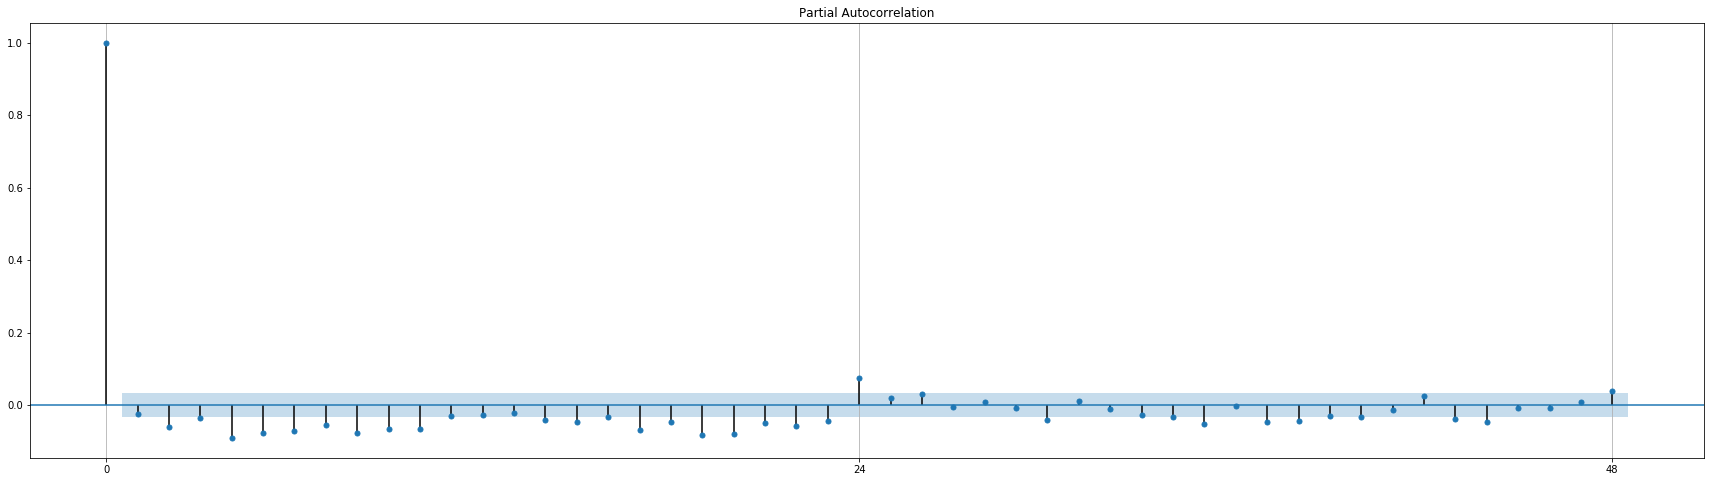

In [210]:
# подберем p - номер последнего несезонного лага, при котором автокорреляция значима
fig, ax = plt.subplots(figsize=figsize)
x = sm.graphics.tsa.plot_pacf(series, lags=24*2, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.xaxis.grid(True)

Подберем модель с наиболее оптимальными параметрами

In [214]:
%%time
Q = 1
q = 2
P = 6
p = 2
D = 1
d = 1
s = 24 # период 24 часа
best_param = test_params(
    data_pred.resid,
    p, q, P, Q, D, d, s
)

1/22: [0, 0, 0, 0]
45998.535209837704
2/22: [0, 0, 0, 0]
45998.535209837704
3/22: [1, 0, 0, 0]
45851.183588393724
4/22: [2, 0, 0, 0]
45845.9667116184
5/22: [0, 1, 0, 0]
45851.452788772185
6/22: [0, 2, 0, 0]
45845.28779860525
7/22: [0, 0, 1, 0]
45940.7274047242
8/22: [0, 0, 2, 0]
45863.94634974535
9/22: [0, 0, 3, 0]
45575.92492106429
10/22: [0, 0, 4, 0]
45002.30788943068
11/22: [0, 0, 5, 0]
44176.188555353474
12/22: [0, 0, 6, 0]
43246.73094161063
13/22: [0, 0, 0, 1]
45340.26768041318
14/22: [2, 2, 6, 1]
43246.643470909214
15/22: [1, 2, 6, 1]
42977.80330337248
16/22: [0, 2, 6, 1]
43232.5234579852
17/22: [1, 1, 6, 1]
43239.741949249394
18/22: [1, 2, 5, 1]
43287.431528700436
19/22: [1, 2, 6, 0]
42986.08604718881
Wall time: 1h 3min 56s


In [215]:
best_param

[1, 2, 6, 1]

In [230]:
%%time
model = calc_sarimax(
    data_pred.resid,
    order=(best_param[0], d, best_param[1]),
    seasonal_order=(best_param[2], D, best_param[3], s),
    simple_differencing=False,
    return_model=True
)

C:\Users\Dmitry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Dmitry\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Wall time: 20min 38s


In [233]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                resid   No. Observations:                 3648
Model:             SARIMAX(1, 1, 2)x(6, 1, [1], 24)   Log Likelihood              -21947.598
Date:                              Wed, 01 Apr 2020   AIC                          43917.197
Time:                                      02:15:48   BIC                          43985.418
Sample:                                  01-01-2016   HQIC                         43941.493
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8388      0.008    110.967      0.000       0.824       0.854
ma.L1         -0.91

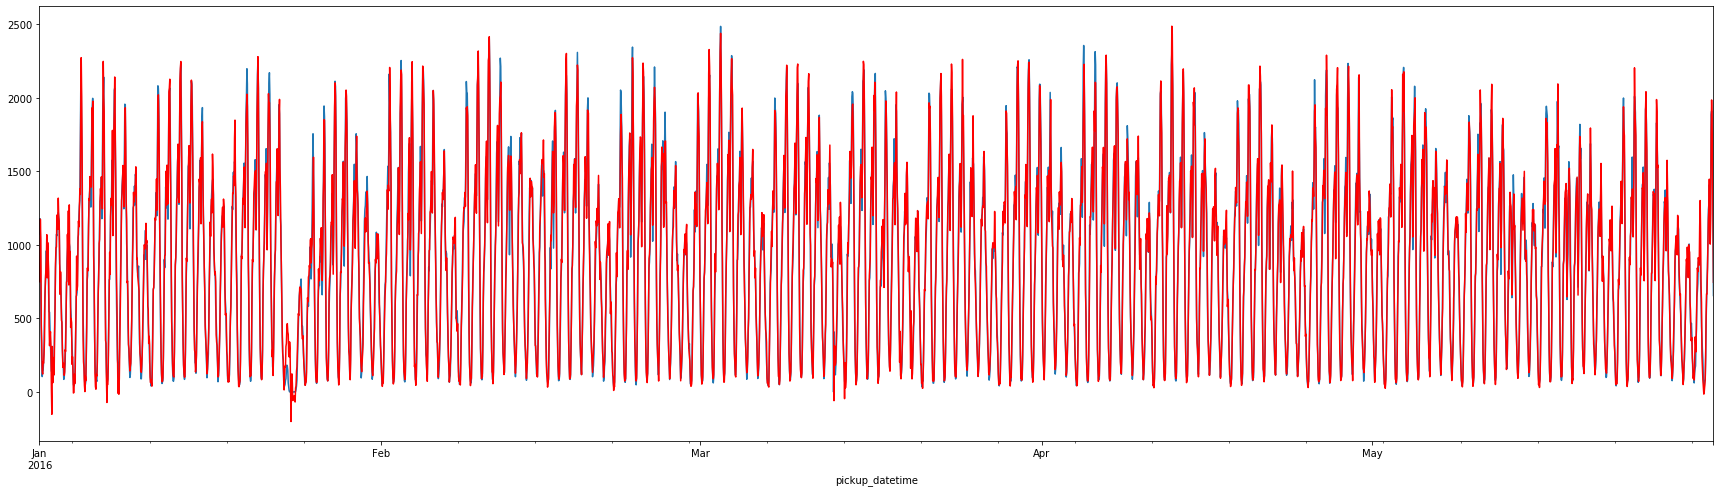

In [231]:
# итоговый прогноз - сумма прогноза линейной регрессии и построенной модели по ее остаткам
data_pred['model'] = data_pred.loc[:, 'pred'] + model.fittedvalues

# результаты за 5 месяцев
plt.figure(figsize=figsize)
data_pred.trip_count_sum.plot()
data_pred.model.plot(color='r')

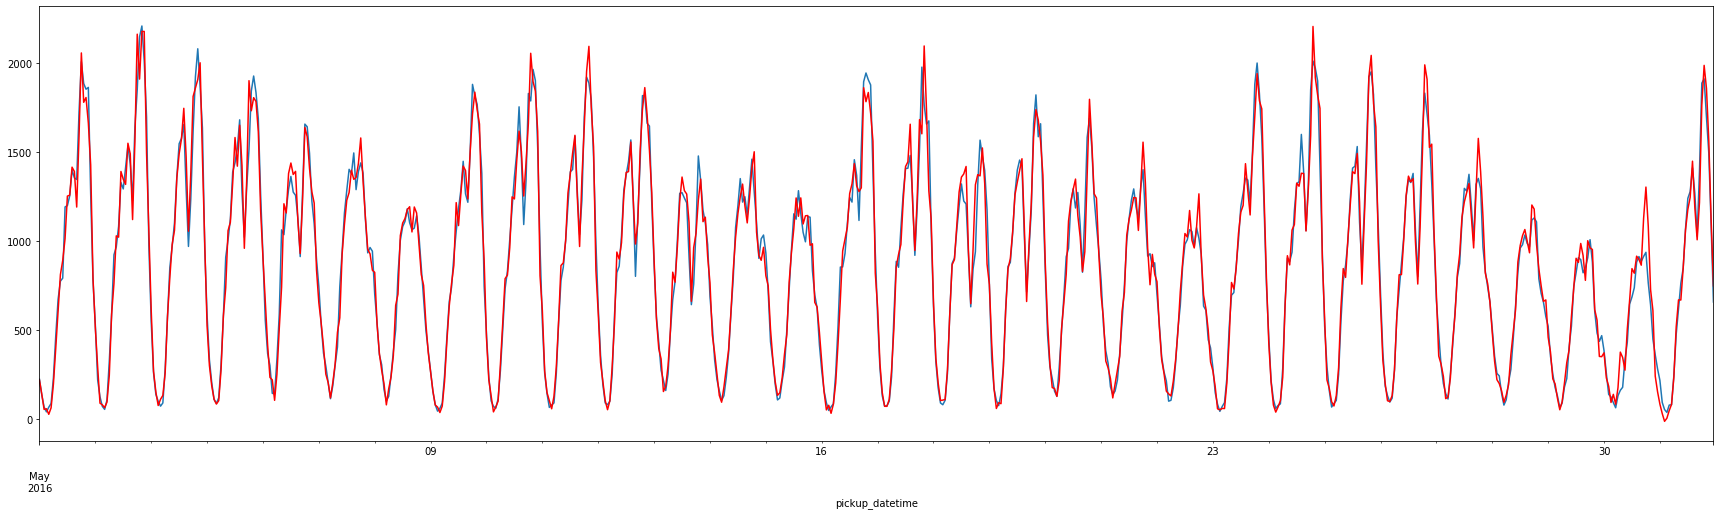

In [232]:
# результаты за 1 месяц
plt.figure(figsize=figsize)
data_pred.tail(24*30).trip_count_sum.plot()
data_pred.tail(24*30).model.plot(color='r')

В целом, модель удалось улучшить. По сравнению с построенной моделью за 2 года, модель за 5 месяцев лучше описывает данные. Это связано с уменьшением объема выборки, в результате чего структура данных стала проще, а также с выключением параметра simple_differencing. С включенным параметром модель обучается значительно быстрее, однако, он ухудшает конечный результат. Кроме того, качество выросло за счет более точного построения исходной модели линейной регрессии. Однако, видно, что модель иногда плохо описывает суточную сезонность, например, утренние и вечерние пики, но скорее всего, это отклонения в пределах погрешности